In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

# Custom Python Files
from dataprep.dataPrep import cleanData
from dataprep.modelPrep import model_prep
from dataprep.modelPrep import plotROCCurve

In [2]:
xcols = ['callsPerQuarter','associateddeals','sessionsPerDay','callcycle_numeric']

# List of interaction terms (each their own sublist)
interactionList = [ ['callsPerQuarter', 'associateddeals'],
                    ['assoccontacts', 'associateddeals'],
                    ['assoccontacts', 'MRR'],
]

termDict = {
    "callcycle_numeric" : 2 # Higher level terms desired
}


ycol = "churn"

df = cleanData("PSCCustomerData.csv", boxcox=True)

X, y, xcolnames = model_prep(df,xcols,ycol, higherTerms=True, termDict=termDict, interactionTerms=True, interactionList = interactionList, standardize=False)

## Final Logistic Regression Model

In [3]:
# Model building and KFold
lr = linear_model.LogisticRegression(class_weight='balanced',penalty='none', max_iter=10000)

#fit model
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

### Logistic Regression Deep Dive

### Variable Selection

In [9]:
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

lr = linear_model.LogisticRegression(class_weight='balanced', penalty='none', max_iter=10000)
efs1 = EFS(lr, 
           min_features=1,
           max_features=10,
           scoring='f1',
           print_progress=True,
           cv=5)

# Create a efs fit
efs1 = efs1.fit(X, y)

print('Best F1 error: %.2f' % efs1.best_score_)
## Print the IDX of the best features 
print('Best subset:', efs1.best_idx_)

Features: 1023/1023Best F1 error: 0.56
Best subset: (0, 1, 2, 4, 5, 6, 7, 8)


In [18]:
sel_f = SelectKBest(f_classif, k=8)
X_train_f = sel_f.fit_transform(X, y)

kbestNames = np.array(xcolnames)
bools = np.array(sel_f.get_support())

kbestNames[bools]

array(['associateddeals', 'sessionsPerDay',
       'callsPerQuarter assoccontacts', 'callsPerQuarter associateddeals',
       'assoccontacts associateddeals', 'assoccontacts MRR',
       'associateddeals MRR', 'sessionsPerDay daysAsCustomer'],
      dtype='<U33')

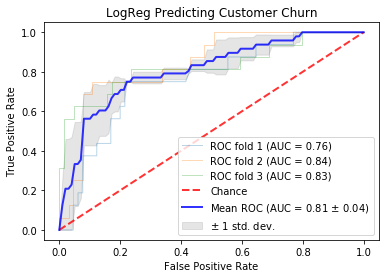

In [3]:
seed = 1234

# Model building and KFold
lr = linear_model.LogisticRegression(class_weight='balanced', penalty='none', max_iter=10000)
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)

# initialization params
pred_test_full = y.copy()
cv_score =[]
i=1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

for train_index,test_index in kf.split(X,y):
    xtr,xvl = X[train_index],X[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    #fit model
    lr.fit(xtr,ytr)

    #get prediction data
    pred_test = lr.predict_proba(xvl)[:,1]
    pred_test_full[yvl] = lr.predict_proba(xvl)[:,1]

    # ROC Curve Plotting
    viz = plot_roc_curve(lr, xvl, yvl,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    i+=1

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="LogReg Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()

### Variable Importance Metrics

#### Variable Importance through RFE

In [4]:
from sklearn.feature_selection import RFE

selector = RFE(lr, n_features_to_select=1)
selector.fit(X, y)

order = np.array(selector.ranking_)

pd.DataFrame(order.T, index=xcolnames, columns=["Rank"]).sort_values(by="Rank")

,Rank
sessionsPerDay,1
callsPerQuarter,2
callsPerQuarter associateddeals,3
associateddeals,4
assoccontacts associateddeals,5
callcycle_numeric,6
assoccontacts MRR,7
callcycle_numeric_2,8
